This notebook is for testing MCMC with toy example. The number of bits were changed to 3 in config file for this example.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import random
from random import shuffle, randrange
from collections import defaultdict
import utilities

import matplotlib.pyplot as plt
import seaborn as sns

import json

import AgentClass
import const
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import copy

In [2]:
%matplotlib inline

In [3]:
def get_tau_distr():
        lower = 0
        upper = 1
        mu = 0.5
        sigma = 0.1
        N = 1000
        
        samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
        
        return samples

In [4]:
def create_environment():
    list_agents = []
    tau_distr = get_tau_distr()
    
    for i in range(num_agents):
        in_state = np.random.randint(2, size=number_of_bits).tolist()
        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)
        
    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 10, 0.5, seed= 0)
#    nx.draw(G, with_labels=True, font_weight='bold') # to draw agents
    df = nx.to_pandas_adjacency(G, dtype=int)
    
    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}
    
    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])
            
    return list_agents

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name, 
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, coh_matrix, list_agents, end_time):
    d = []
    for t in range(end_time):    
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, coh_matrix) 
         
        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Name':agt.name,
                   'Agent_Dissonance':agt.dissonance_lst,
                   'Time':t,
                   'Current State':agt.knowledge_state,
                   'Next State':agt.next_state}
            
            d.append(row)
        
        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None
            
    return pd.DataFrame(d)

In [7]:
# kbits_dict = defaultdict(list)


# for i in range(10):
#     kbits_dict['State'].append(i)
#     kbits_dict['binary'].append('{0:02b}'.format(i))
    
#     kbits_dict['binary_list'].append(list('{0:04b}'.format(i))[::-1])

# kbits_mapper_df = pd.DataFrame(kbits_dict)
# kbits_mapper_df.set_index('State', inplace=True)
# kbits_mapper_df.drop('binary', inplace=True, axis=1)
# kbits_mapper_df_dict = kbits_mapper_df.to_dict(orient='index')

In [8]:
# '{0:04b}'.format(1)

# Running simulation

In [9]:
random.seed(1)
np.random.seed(1)
end_simulation_time = 100
alphas = [0.5]
    
# first create environment
agents_list = create_environment()
    
# get network of the agents
agent_network_df = get_network_df(agents_list) 
        
# for saving
# agent_network_df.to_json('simulations_new/test_network.json',orient='records', lines=True)
                
constants = const.Constants()
coherence_matrix = constants.get_coh_matrix().tolist()        
    
# run simulation
for alpha in alphas:
    
    record_df = run_simulation(alpha, coherence_matrix, copy.deepcopy(agents_list), end_simulation_time)
    record_df['Current State'] = record_df['Current State'].apply(lambda row: utilities.bool2int(row))
    record_df['Next State'] = record_df['Next State'].apply(lambda row: utilities.bool2int(row))
    df = record_df.groupby(['Current State', 'Next State']).size().to_frame('Count').reset_index()

In [10]:
record_df.head()

,Agent_Name,Agent_Dissonance,Time,Current State,Next State
0,agent0,"[0.1312755144691944, 0.38273323822517796, 0.38...",0,3,3
1,agent1,"[0.1339821467687179, 0.32665751559233436, 0.41...",0,3,3
2,agent2,"[0.041093071215441285, 0.5866286134334713, 0.2...",0,5,5
3,agent3,"[0.1648226993283943, 0.1648226993283943, 0.810...",0,7,6
4,agent4,"[0.2447973505213831, 0.34829200110176955, 0.34...",0,3,7


In [11]:
df.sort_values(by='Count', ascending=False).head()

,Current State,Next State,Count
54,6,6,764
52,6,4,651
62,7,6,396
18,2,2,374
36,4,4,356


In [12]:
pd.DataFrame(coherence_matrix)

,0,1,2
0,0.209442,0.837769,0.418884
1,0.603567,0.301783,0.150892
2,0.661974,0.165493,0.330987
3,0.321610,0.160805,0.643220
4,0.153184,0.306368,0.612735
5,0.447452,0.894904,0.223726
6,0.312030,0.624059,0.156015
7,0.859535,0.429768,0.214884


In [13]:
record_df

,Agent_Name,Agent_Dissonance,Time,Current State,Next State
0,agent0,"[0.1312755144691944, 0.38273323822517796, 0.38...",0,3,3
1,agent1,"[0.1339821467687179, 0.32665751559233436, 0.41...",0,3,3
2,agent2,"[0.041093071215441285, 0.5866286134334713, 0.2...",0,5,5
3,agent3,"[0.1648226993283943, 0.1648226993283943, 0.810...",0,7,6
4,agent4,"[0.2447973505213831, 0.34829200110176955, 0.34...",0,3,7
...,...,...,...,...,...
9995,agent95,"[0.24751671168287026, 0.24751671168287026, 0.3...",99,6,3
9996,agent96,"[0.47769553595374353, 0.7009654255230753, 0.59...",99,6,6
9997,agent97,"[0.05588887745794994, 0.6460435293341216, 0.76...",99,0,2
9998,agent98,"[0.8326781774610197, 0.25693918300295604, 0.25...",99,7,4


# Using pyMC3

In [14]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json

matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 500

In [15]:
def int2bool(val):
    bin_values = '{0:0{size}b}'.format(val, size=number_of_bits)
    return list(map(int, bin_values))

In [18]:
with pm.Model() as model:
    # Create the alpha and beta parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=1.0)
    alpha = pm.Uniform('alpha', 0, 1)
    beta = pm.Uniform('beta', 0, shape=(1,number_of_bits))
    kappa = pm.Uniform('kappa', 0, 1)
    meta = pm.Uniform('meta', 0, 1, shape=(2**number_of_bits,number_of_bits))
    current_states = record_df['Current State'].tolist()
    next_state = record_df['Next State'].tolist()
    dissonance = np.array(record_df['Agent_Dissonance'].tolist())

    next_states = np.array([int2bool(i) for i in next_state])

In [19]:
with model:  
    # Need to fix the output_fun
    output_fun = alpha*(1. / (1. + tt.exp(-8.0*(beta - kappa)))) +(1-alpha)*meta[current_states]
    p = pm.Deterministic('p', output_fun)
    # Create the bernoulli parameter which uses the observed dat
    observed = pm.Bernoulli('obs', p, observed=next_states)
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    trace = pm.sample(N_SAMPLES, njobs=2, tune=300);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [meta, kappa, beta, alpha]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 1600/1600 [07:43<00:00,  1.31draws/s]
The acceptance probability does not match the target. It is 0.8898997079463062, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [20]:
# Extract the alpha and beta samples
alpha_samples = trace["alpha"][500:, None]
beta_samples = trace["beta"][500:, None]
kappa_samples = trace["kappa"][500:, None]
meta_samples = trace['meta'][500:, None]

Text(0, 0.5, 'Probability Density')

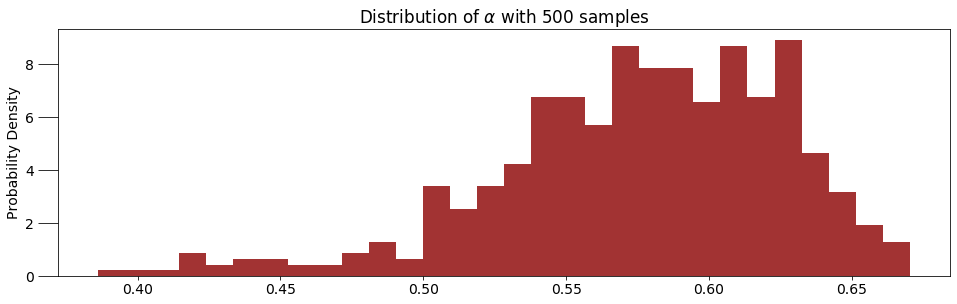

In [21]:
figsize(16, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')

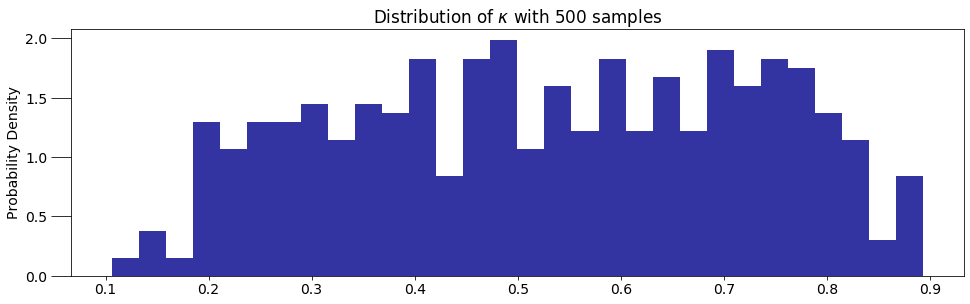

In [23]:
figsize(16, 10)

plt.subplot(212)
plt.title(r"""Distribution of $\kappa$ with %d samples""" % N_SAMPLES)
plt.hist(kappa_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

In [24]:
pd.DataFrame(meta_samples.mean(0)[0])

,0,1,2
0,0.368227,0.766301,0.343281
1,0.090715,0.171784,0.466023
2,0.267129,0.666895,0.832900
3,0.644762,0.695495,0.890064
4,0.340605,0.139212,0.222436
5,0.782661,0.862170,0.669657
6,0.924941,0.149860,0.453380
7,0.757717,0.359295,0.205341


In [25]:
pd.DataFrame(coherence_matrix)

,0,1,2
0,0.209442,0.837769,0.418884
1,0.603567,0.301783,0.150892
2,0.661974,0.165493,0.330987
3,0.321610,0.160805,0.643220
4,0.153184,0.306368,0.612735
5,0.447452,0.894904,0.223726
6,0.312030,0.624059,0.156015
7,0.859535,0.429768,0.214884


In [26]:
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()
kappa_est = kappa_samples.mean()

In [27]:
alpha_est

0.5759215106551137